In [1]:
!pip install pandas scikit-learn


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kazanova/sentiment140")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sentiment140


In [5]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np  # 👈 新加的库
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 读取数据（原始6列: label, id, date, query, user, text）
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)
df.columns = ['label', 'id', 'date', 'query', 'user', 'text']

# 只保留正负类（0=negative, 4=positive）
df = df[df['label'] != 2]
df['label'] = df['label'].replace({0: 0, 4: 1})



# Train/Test split for visualization
text_train, text_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42
)

# 特征提取: TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train = vectorizer.fit_transform(text_train)
X_test = vectorizer.transform(text_test)

# Feature names and label assignment
feature_names = vectorizer.get_feature_names_out()
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


# 打印 top 20 TF-IDF 关键词 🔍
feature_names = vectorizer.get_feature_names_out()
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

tfidf_means = X_train.mean(axis=0).A1
top_indices = np.argsort(tfidf_means)[::-1][:20]

print("Top 20 keywords by average TF-IDF score:")
for i in top_indices:
    print(f"{feature_names[i]}: {tfidf_means[i]:.4f}")

# 训练模型 + 5折交叉验证
model = LogisticRegression(max_iter=1000)
X_all = vectorizer.transform(df['text'])
y_all = df['label']
scores = cross_val_score(model, X_all, y_all, cv=5, scoring='accuracy')

print(f"Cross-validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)

print(f"Test Set Accuracy: {test_acc:.4f}")

Top 20 keywords by average TF-IDF score:
just: 0.0174
good: 0.0157
day: 0.0141
work: 0.0124
like: 0.0122
love: 0.0117
today: 0.0116
going: 0.0115
http: 0.0111
lol: 0.0104
quot: 0.0104
got: 0.0101
time: 0.0100
thanks: 0.0100
know: 0.0098
don: 0.0091
com: 0.0090
im: 0.0089
really: 0.0089
want: 0.0085
Cross-validation Accuracy: 0.7627 ± 0.0030
Test Set Accuracy: 0.7678


# Visualization

**learning curve**

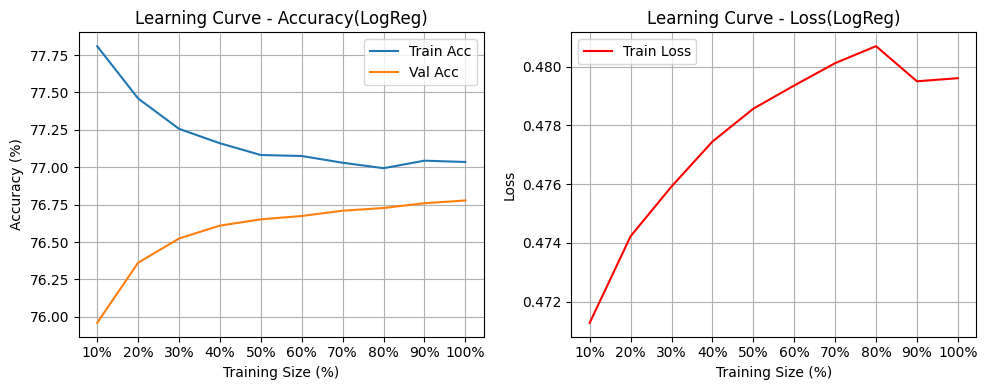

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss

train_accuracies = []
val_accuracies = []
train_losses = []

percentages = np.linspace(0.1, 1.0, 10)
tick_labels = [f"{int(p * 100)}%" for p in percentages]

for frac in percentages:
    n = int(frac * X_train.shape[0])
    X_sub = X_train[:n]
    y_sub = y_train[:n]

    model = LogisticRegression(max_iter=1000)
    model.fit(X_sub, y_sub)

    # Train predictions
    y_train_pred = model.predict(X_sub)
    y_train_proba = model.predict_proba(X_sub)
    train_acc = accuracy_score(y_sub, y_train_pred)
    train_loss = log_loss(y_sub, y_train_proba)

    # Validation predictions
    y_val_pred = model.predict(X_test)
    val_acc = accuracy_score(y_test, y_val_pred)

    train_accuracies.append(train_acc * 100)
    val_accuracies.append(val_acc * 100)
    train_losses.append(train_loss)

# Plot
plt.figure(figsize=(10, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(percentages * 100, train_accuracies, label="Train Acc")
plt.plot(percentages * 100, val_accuracies, label="Val Acc")
plt.xlabel("Training Size (%)")
plt.ylabel("Accuracy (%)")
plt.title("Learning Curve - Accuracy(LogReg)")
plt.xticks(percentages * 100, tick_labels)
plt.grid(True)
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(percentages * 100, train_losses, color='red', label="Train Loss")
plt.xlabel("Training Size (%)")
plt.ylabel("Loss")
plt.title("Learning Curve - Loss(LogReg)")
plt.xticks(percentages * 100, tick_labels)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


**Confusion Matrix**

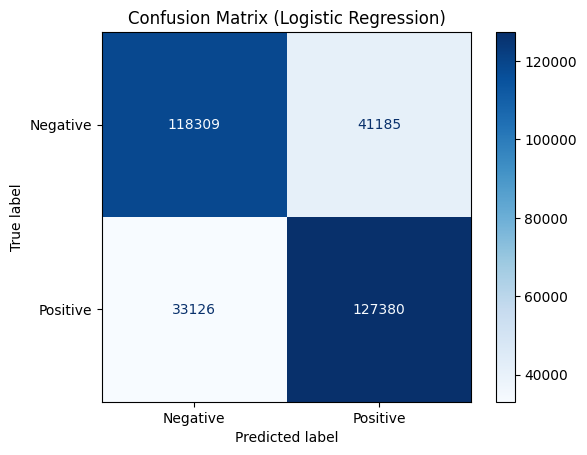

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


y_pred = model.predict(X_test)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])


disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()


**ROC/AUC**

---



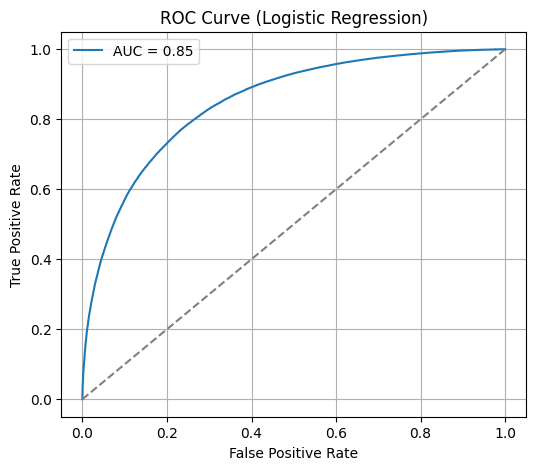

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Logistic Regression)")
plt.grid(True)
plt.legend()
plt.show()


**Error vs Length**

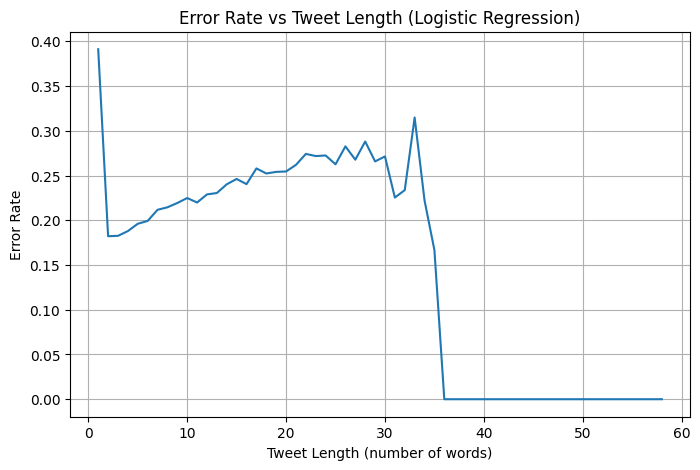

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

text_test = text_test.reset_index(drop=True)
tweet_lengths = text_test.str.split().apply(len)

errors = (y_pred != y_test).astype(int)


df_error = pd.DataFrame({
    "length": tweet_lengths,
    "error": errors
})

df_grouped = df_error.groupby("length")["error"].mean()


plt.figure(figsize=(8, 5))
df_grouped.plot()
plt.title("Error Rate vs Tweet Length (Logistic Regression)")
plt.xlabel("Tweet Length (number of words)")
plt.ylabel("Error Rate")
plt.grid(True)
plt.show()


**Evaluation Matrix**

In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))


              precision    recall  f1-score   support

    Negative       0.78      0.74      0.76    159494
    Positive       0.76      0.79      0.77    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000

